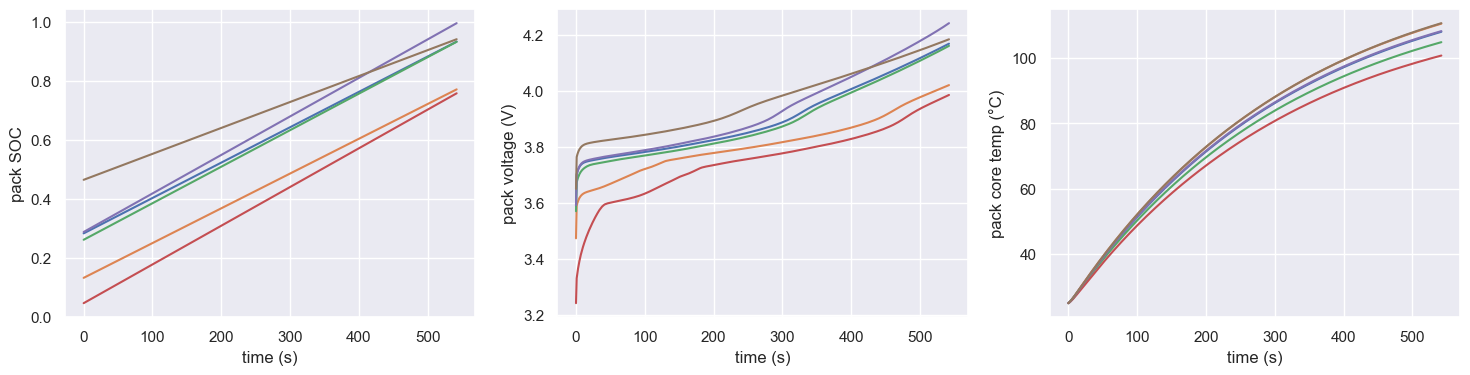

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LIBEnv.LIB_gym import LIBPackEnv
import seaborn as sns
sns.set_theme()

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1, use_switch=False)

pack_res=[]
rewards = []
pack_res.append(env.reset(0)[0].reshape(3,6))
done = False
while not done:
    next_state, reward, done, _, info = env.step(np.ones(7))
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)

pack_res = np.array(pack_res)
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(pack_res[:,0,:])
plt.xlabel('time (s)')
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(1,3,2)
plt.plot(pack_res[:,1,:]*(env.max_voltage-env.min_voltage)+env.min_voltage)
plt.xlabel('time (s)')
plt.ylabel('pack voltage (V)')
plt.grid('on')
plt.subplot(1,3,3)
plt.plot(pack_res[:,2,:]*env.T)
plt.xlabel('time (s)')
plt.ylabel('pack core temp (°C)')
plt.grid('on')

# MPC Controller

In [46]:
import numpy as np
from scipy.optimize import minimize
import copy

class MPC_Controller:
    def __init__(self, horizon):
        self.horiz = horizon

    def mpc_cost(self, u_k, battery_model):
        mpc_battery_model = copy.deepcopy(battery_model)
        u_k = u_k.reshape(self.horiz, 6).T
        cost = 0.0

        for i in range(self.horiz):
            action = np.hstack([u_k[:,i].ravel(),1])
            next_state, reward, done, _, info = mpc_battery_model.step(action)
            cost -= reward
        return cost

    def optimize(self, battery_model):
        bnd = ([(0, 1)]*6)*self.horiz
        result = minimize(self.mpc_cost, args=(battery_model), x0 = np.ones((6*self.horiz)), method='SLSQP', bounds = bnd)
        return result.x[:6]

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1, use_priority=True)

MPC_HORIZON = 5
MPC_controller = MPC_Controller(MPC_HORIZON)
charge_current = MPC_controller.optimize(env)
charge_current

array([0.99986717, 0.99986717, 0.99986717, 0.99986717, 0.99986717,
       0.99986717])

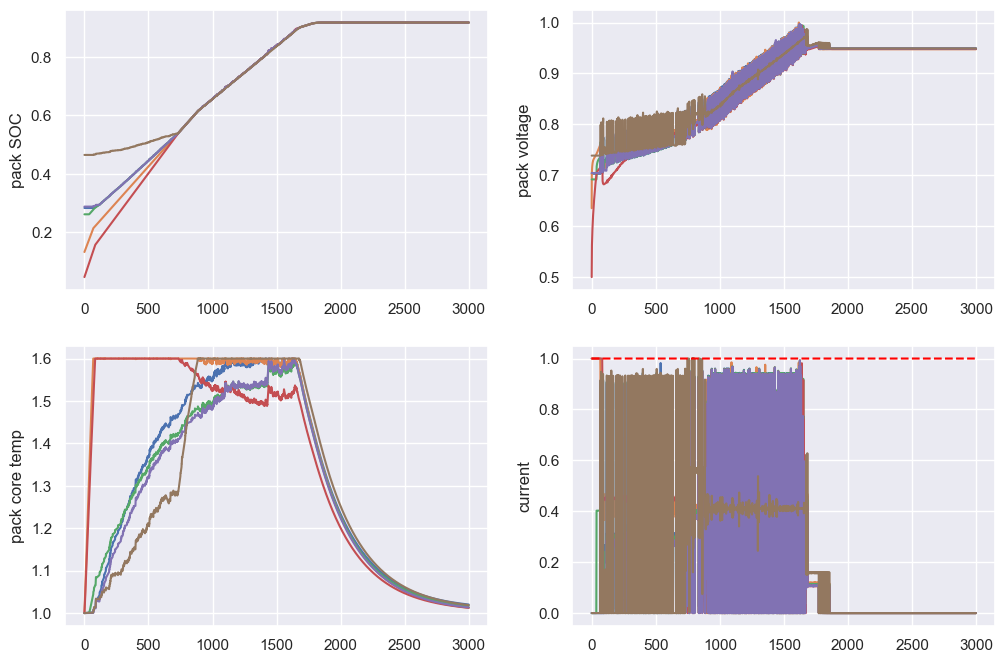

In [59]:
env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1, use_priority=False)

MPC_HORIZON = 1
MPC_controller = MPC_Controller(MPC_HORIZON)

pack_res=[]
rewards = []
actions = []

done = False
pack_res.append(env.reset(0)[0].reshape(3,6))
while not done:
    MPC_action = MPC_controller.optimize(env)
    MPC_action = np.hstack([MPC_action,1])
    next_state, reward, done, _, info = env.step(MPC_action)
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(MPC_action)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:-1].reshape(-1,6+1)[:,:-1])
plt.plot(np.array(actions)[:-1].reshape(-1,6+1)[:,-1], "--", color='red')
plt.ylabel('current')
plt.grid('on')

# SoC Plot

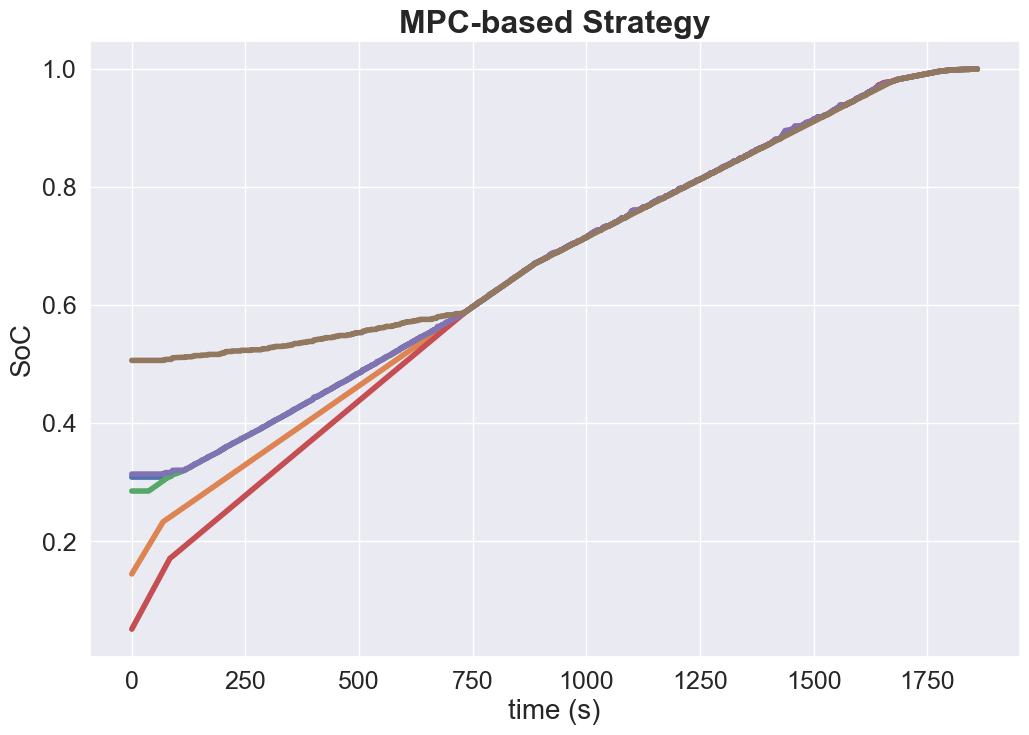

In [124]:
plt.figure(figsize=(12,8))
import matplotlib
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
plt.plot(pack_res[:1861,0,:]*(1/pack_res[:-1,0,:].max()), linewidth=4)
plt.ylabel('SoC', fontsize='20')
plt.xlabel('time (s)', fontsize='20')
plt.title('MPC-based Strategy', fontsize='23', weight='bold')
plt.grid('on')